In [ ]:
!pip install pulp
!pip install folium
!pip install geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 32.6 MB/s eta 0:00:00


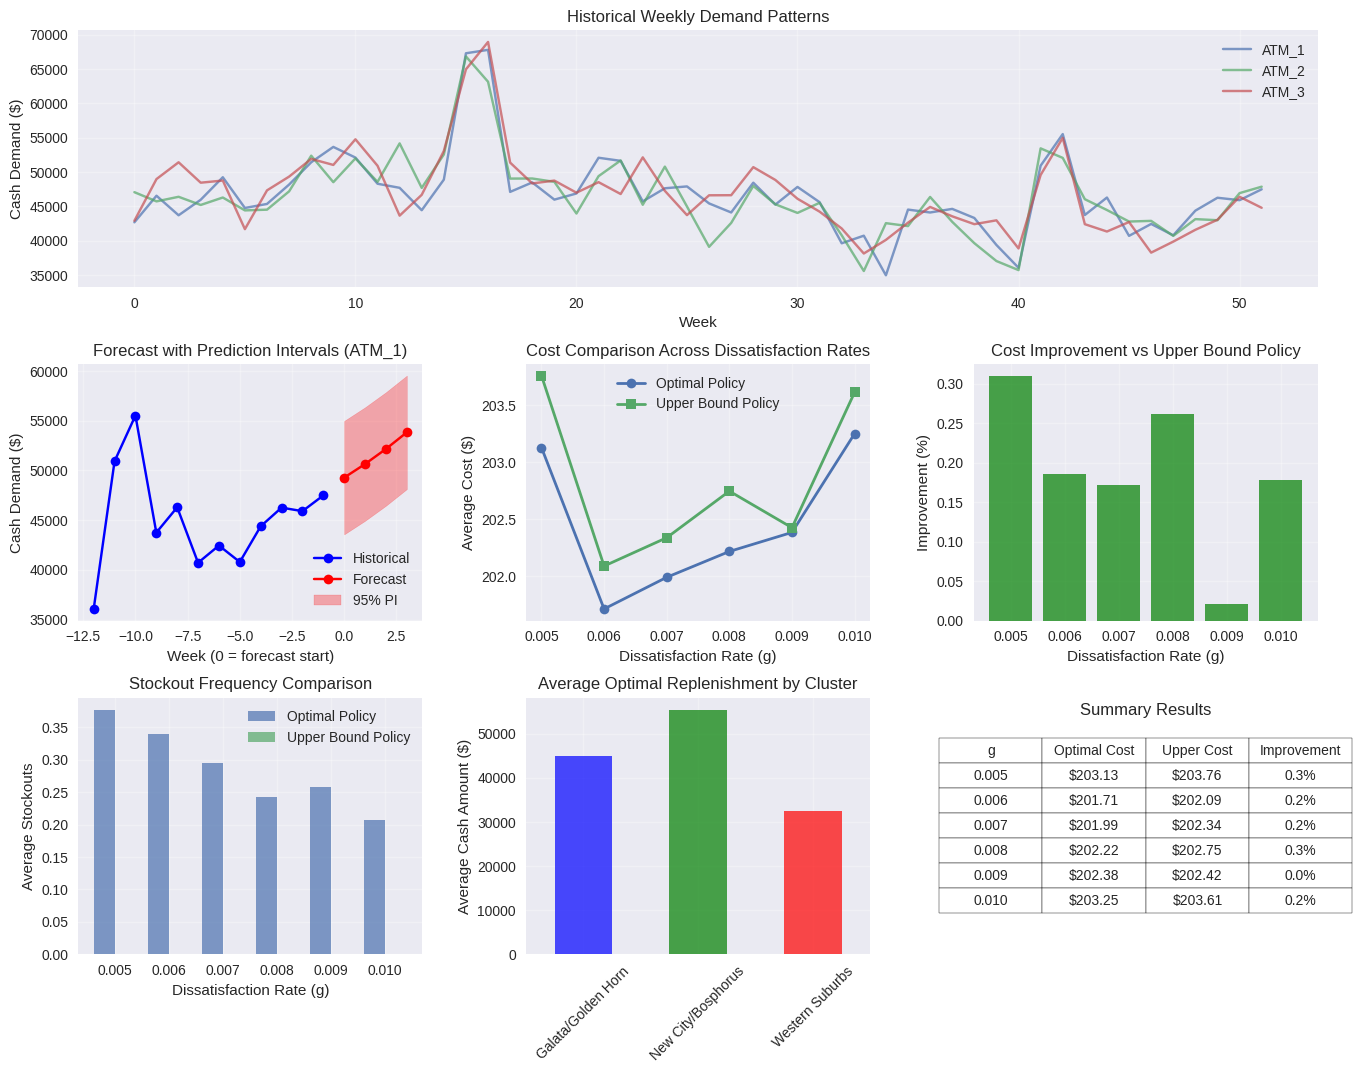


ATM CASH REPLENISHMENT OPTIMIZATION
      Model Implementation

Problem Setup:
- Number of ATMs: 10
- Historical data: 52 weeks
- Planning horizon: 4 weeks
- Interest cost rate (c): 0.001
- Fixed penalty cost (h): $10
- Dissatisfaction rates (g): [0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

ATM Distribution by Cluster:
- Western Suburbs: 5 ATMs
- New City/Bosphorus: 3 ATMs
- Galata/Golden Horn: 2 ATMs

Key Findings:
    g  Cost_Optimal  Cost_Upper  Improvement_%  Stockouts_Optimal  Stockouts_Upper
0.005    203.128220  203.759134       0.309637              0.377              0.0
0.006    201.711724  202.088199       0.186293              0.339              0.0
0.007    201.989492  202.336838       0.171667              0.295              0.0
0.008    202.216110  202.745571       0.261146              0.242              0.0
0.009    202.383336  202.424707       0.020438              0.258              0.0
0.010    203.249691  203.612375       0.178125              0.207              0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


[Map saved and downloaded as 'atm_locations.html']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns

# Set the Style and Seed
plt.style.use('seaborn-v0_8')
np.random.seed(321)

# Problem parameters from the paper
nATMs = 10  # Increased to better show clustering
nWeeks = 4  # 4-week planning horizon
historical_weeks = 52  # Historical data
c = 0.001   # Interest cost rate
h = 10      # Fixed penalty cost
g_values = [0.005, 0.006, 0.007, 0.008, 0.009, 0.010]  # Range from paper

# Generate ATM data using the paper's clustering approach
clusters = ['New City/Bosphorus', 'Galata/Golden Horn', 'Western Suburbs']
cluster_distribution = [3, 2, 5]  # Simplified version of paper's 31, 5, 62
cluster_assignments = []
for cluster, count in zip(clusters, cluster_distribution):
    cluster_assignments.extend([cluster] * count)

# Location-related variables in the paper
df_atms = pd.DataFrame({
    "ATM": [f"ATM_{i+1}" for i in range(nATMs)],
    "Cluster": cluster_assignments,
    "points_of_interest": np.random.randint(0, 20, nATMs),
    "other_atms_street": np.random.randint(0, 5, nATMs),
    "population_density": np.random.randint(1000, 10000, nATMs),
    "commercial_buildings": np.random.randint(0, 10, nATMs)
})

# Create historical data with trends and seasonality
def generate_historical_data(cluster, weeks=52):
    """Generate historical data following paper's approach"""
    # Base demand per cluster
    base_demand = {
        'New City/Bosphorus': 45000,  # Business district
        'Galata/Golden Horn': 35000,  # Tourist area
        'Western Suburbs': 25000      # Residential
    }[cluster]

    # Time array
    t = np.arange(weeks)

    # Trend component (gradual increase)
    trend = base_demand * (1 + 0.02 * t / 52)

    # Seasonal component
    seasonal = base_demand * 0.1 * np.sin(2 * np.pi * t / 52)

    # Weekly pattern (higher on Fridays)
    weekly = base_demand * 0.05 * np.sin(2 * np.pi * t / 7)

    # Holiday effects
    holiday_effect = np.ones(weeks)
    holiday_weeks = [15, 16, 41, 42]  # Estimated festival weeks
    for week in holiday_weeks:
        if week < weeks:
            holiday_effect[week] = 1.3

    # Combine all components
    demand = (trend + seasonal + weekly) * holiday_effect

    # Add noise
    noise = np.random.normal(0, base_demand * 0.05, weeks)
    demand += noise

    return np.maximum(demand, 1000)

# Generate historical data
historical_data = {}
for _, atm in df_atms.iterrows():
    historical_data[atm['ATM']] = generate_historical_data(atm['Cluster'])

# Implement the detrending approach in the paper
def detrend_data(y_data):
    """Non-parametric regression for detrending"""
    x_data = np.arange(len(y_data))

    # Simple polynomial fit for trend
    z = np.polyfit(x_data, y_data, 3)
    p = np.poly1d(z)
    trend = p(x_data)

    detrended = y_data - trend
    return detrended, trend

# A simplified regression model for forecasting
def forecast_with_intervals(atm_data, historical):
    """Create forecast with prediction intervals as in paper"""
    forecasts = {}

    for _, atm in atm_data.iterrows():
        # Detrend
        data = historical[atm['ATM']]
        detrended, trend = detrend_data(data)

        # Simple regression with detrended data
        X = np.arange(len(detrended)).reshape(-1, 1)
        y = detrended

        model = LinearRegression()
        model.fit(X, y)

        # Forecast
        future_X = np.arange(len(data), len(data) + nWeeks).reshape(-1, 1)
        detrended_forecast = model.predict(future_X)

        # Extend trend
        x_future = np.arange(len(data), len(data) + nWeeks)
        z = np.polyfit(np.arange(len(trend)), trend, 3)
        p = np.poly1d(z)
        trend_forecast = p(x_future)

        # Combine
        point_forecast = detrended_forecast + trend_forecast

        # Calculate prediction intervals using the last eight weeks as in the paper
        recent_errors = y[-8:] - model.predict(X[-8:])
        std_error = np.std(recent_errors) * 1.5  # Adjust for weekly aggregation

        # 95% prediction interval
        lower = point_forecast - 1.96 * std_error
        upper = point_forecast + 1.96 * std_error

        forecasts[atm['ATM']] = {
            'point': point_forecast,
            'lower': lower,
            'upper': upper
        }

    return forecasts

# Generate forecasts
forecasts = forecast_with_intervals(df_atms, historical_data)

# Robust optimization (using Equation 4 from the paper)
def robust_optimization(L, U, c, h, g):
    """Apply Equation 4 from the paper"""
    x_star = (h + g * U + L * c) / (c + g)
    return np.clip(x_star, L, U)

# Complete analysis for all g values
results_all = []

for g in g_values:
    weekly_results = []

    for week in range(nWeeks):
        for _, atm in df_atms.iterrows():
            atm_id = atm['ATM']
            L = forecasts[atm_id]['lower'][week]
            U = forecasts[atm_id]['upper'][week]

            # Optimal replenishment
            x_optimal = robust_optimization(L, U, c, h, g)

            weekly_results.append({
                'ATM': atm_id,
                'Week': week + 1,
                'g': g,
                'Lower': L,
                'Upper': U,
                'Optimal': x_optimal,
                'Cluster': atm['Cluster']
            })

    results_all.extend(weekly_results)

results_df = pd.DataFrame(results_all)

# Simulate costs and calculate improvements
cost_comparison = []

for g in g_values:
    total_cost_optimal = 0
    total_cost_upper = 0
    stockouts_optimal = 0
    stockouts_upper = 0

    # Filter results for this g
    g_results = results_df[results_df['g'] == g]

    # Simulate actual demands
    n_sims = 1000
    for _ in range(n_sims):
        for _, row in g_results.iterrows():
            # Generate actual demand within prediction interval
            actual = np.random.uniform(row['Lower'], row['Upper'])

            # Calculate costs
            if row['Optimal'] >= actual:
                cost_opt = c * (row['Optimal'] - actual)
            else:
                cost_opt = h + g * (actual - row['Optimal'])
                stockouts_optimal += 1

            if row['Upper'] >= actual:
                cost_upper = c * (row['Upper'] - actual)
            else:
                cost_upper = h + g * (actual - row['Upper'])
                stockouts_upper += 1

            total_cost_optimal += cost_opt
            total_cost_upper += cost_upper

    # Average across simulations
    avg_cost_optimal = total_cost_optimal / n_sims
    avg_cost_upper = total_cost_upper / n_sims
    avg_stockouts_optimal = stockouts_optimal / n_sims
    avg_stockouts_upper = stockouts_upper / n_sims

    improvement = (avg_cost_upper - avg_cost_optimal) / avg_cost_upper * 100

    cost_comparison.append({
        'g': g,
        'Cost_Optimal': avg_cost_optimal,
        'Cost_Upper': avg_cost_upper,
        'Improvement_%': improvement,
        'Stockouts_Optimal': avg_stockouts_optimal,
        'Stockouts_Upper': avg_stockouts_upper
    })

cost_df = pd.DataFrame(cost_comparison)

# Detailed visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Historical demand pattern
ax1 = fig.add_subplot(gs[0, :])
for atm_id in list(historical_data.keys())[:3]:  # Show first 3 ATMs
    ax1.plot(historical_data[atm_id], label=atm_id, alpha=0.7)
ax1.set_title('Historical Weekly Demand Patterns')
ax1.set_xlabel('Week')
ax1.set_ylabel('Cash Demand ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Forecast with intervals (Example: ATM 1)
ax2 = fig.add_subplot(gs[1, 0])
example_atm = 'ATM_1'
hist_data = historical_data[example_atm][-12:]  # Last 12 weeks
forecast_data = forecasts[example_atm]

weeks_hist = np.arange(-12, 0)
weeks_future = np.arange(0, nWeeks)

ax2.plot(weeks_hist, hist_data, 'o-', label='Historical', color='blue')
ax2.plot(weeks_future, forecast_data['point'], 'o-', label='Forecast', color='red')
ax2.fill_between(weeks_future, forecast_data['lower'], forecast_data['upper'],
                 alpha=0.3, color='red', label='95% PI')
ax2.set_title(f'Forecast with Prediction Intervals ({example_atm})')
ax2.set_xlabel('Week (0 = forecast start)')
ax2.set_ylabel('Cash Demand ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cost comparison
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(cost_df['g'], cost_df['Cost_Optimal'], 'o-', label='Optimal Policy', linewidth=2)
ax3.plot(cost_df['g'], cost_df['Cost_Upper'], 's-', label='Upper Bound Policy', linewidth=2)
ax3.set_title('Cost Comparison Across Dissatisfaction Rates')
ax3.set_xlabel('Dissatisfaction Rate (g)')
ax3.set_ylabel('Average Cost ($)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Improvement percentage
ax4 = fig.add_subplot(gs[1, 2])
bars = ax4.bar(cost_df['g'], cost_df['Improvement_%'], width=0.0008,
               alpha=0.7, color='green')
ax4.set_title('Cost Improvement vs Upper Bound Policy')
ax4.set_xlabel('Dissatisfaction Rate (g)')
ax4.set_ylabel('Improvement (%)')
ax4.grid(True, alpha=0.3)

# Stockout comparison
ax5 = fig.add_subplot(gs[2, 0])
width = 0.0004
x_pos = cost_df['g'].values
ax5.bar(x_pos - width/2, cost_df['Stockouts_Optimal'], width,
        label='Optimal Policy', alpha=0.7)
ax5.bar(x_pos + width/2, cost_df['Stockouts_Upper'], width,
        label='Upper Bound Policy', alpha=0.7)
ax5.set_title('Stockout Frequency Comparison')
ax5.set_xlabel('Dissatisfaction Rate (g)')
ax5.set_ylabel('Average Stockouts')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Cluster analysis
ax6 = fig.add_subplot(gs[2, 1])
cluster_costs = results_df[results_df['g'] == 0.005].groupby('Cluster')['Optimal'].mean()
cluster_costs.plot(kind='bar', ax=ax6, color=['blue', 'green', 'red'], alpha=0.7)
ax6.set_title('Average Optimal Replenishment by Cluster')
ax6.set_ylabel('Average Cash Amount ($)')
ax6.set_xlabel('')
plt.xticks(rotation=45)
ax6.grid(True, alpha=0.3)

# Summary table
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('tight')
ax7.axis('off')
summary_data = []
for _, row in cost_df.iterrows():
    summary_data.append([
        f"{row['g']:.3f}",
        f"${row['Cost_Optimal']:.2f}",
        f"${row['Cost_Upper']:.2f}",
        f"{row['Improvement_%']:.1f}%"
    ])

table = ax7.table(cellText=summary_data,
                  colLabels=['g', 'Optimal Cost', 'Upper Cost', 'Improvement'],
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax7.set_title('Summary Results', y=0.9)

plt.savefig('paper_model_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary report
print(f"\nATM CASH REPLENISHMENT OPTIMIZATION")
print("      Model Implementation")

print(f"\nProblem Setup:")
print(f"- Number of ATMs: {nATMs}")
print(f"- Historical data: {historical_weeks} weeks")
print(f"- Planning horizon: {nWeeks} weeks")
print(f"- Interest cost rate (c): {c}")
print(f"- Fixed penalty cost (h): ${h}")
print(f"- Dissatisfaction rates (g): {g_values}")

print(f"\nATM Distribution by Cluster:")
cluster_counts = df_atms['Cluster'].value_counts()
for cluster, count in cluster_counts.items():
    print(f"- {cluster}: {count} ATMs")

print(f"\nKey Findings:")
print(cost_df.to_string(index=False))
print("\n")

# Create a dynamic map with verified locations
map_center = [41.015, 28.977]
atm_map = folium.Map(location=map_center, zoom_start=11)

cluster_colors = {
    'New City/Bosphorus': 'blue',
    'Galata/Golden Horn': 'red',
    'Western Suburbs': 'green'
}

# District coordinates on land
district_coords = {
    'New City/Bosphorus': {
        'center': [41.08, 29.01],  # Levent/Maslak area (business district)
        'radius': 0.015
    },
    'Galata/Golden Horn': {
        'center': [41.0268, 28.9736],  # Centered more on Galata/Beyoğlu hill area
        'radius': 0.005
    },
    'Western Suburbs': {
        'center': [41.02, 28.91],  # Bakırköy/Zeytinburnu area (residential)
        'radius': 0.02
    }
}

for _, atm in df_atms.iterrows():
    # Obtain the cluster's precise coordinates
    coords = district_coords[atm['Cluster']]

    # Create a random location constrained to land area within the district
    angle = np.random.uniform(0, 2*np.pi)
    radius = np.random.uniform(0, coords['radius'])

    lat = coords['center'][0] + radius * np.cos(angle)
    lon = coords['center'][1] + radius * np.sin(angle)

    # Obtain optimal ATM replenishment (week 1, g = 0.005)
    opt_value = results_df[
        (results_df['ATM'] == atm['ATM']) &
        (results_df['Week'] == 1) &
        (results_df['g'] == 0.005)
    ]['Optimal'].values[0]

    folium.Marker(
        location=[lat, lon],
        popup=f"{atm['ATM']}<br>Cluster: {atm['Cluster']}<br>Optimal: ${opt_value:,.0f}",
        icon=folium.Icon(color=cluster_colors[atm['Cluster']], icon='usd')
    ).add_to(atm_map)

# Add district labels/circles to show regions
for district, coords in district_coords.items():
    folium.Circle(
        location=coords['center'],
        radius=coords['radius']*111000,  # Approximate conversion to meters
        popup=district,
        color=cluster_colors[district],
        fill=True,
        fillOpacity=0.1
    ).add_to(atm_map)

# Display map
display(atm_map)

# Save and download
try:
    from google.colab import files
    atm_map.save('atm_locations.html')
    files.download('atm_locations.html')
    print("\n[Map saved and downloaded as 'atm_locations.html']")
except:
    atm_map.save('atm_locations.html')
    print("\n[Map saved as 'atm_locations.html']")

In [14]:
# Initialize simulation parameters and generate ATM-specific variables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# Set seed for reproducibility
np.random.seed(321)

# Problem parameters from the paper
nATMs = 10  # Increased to better show clustering
nWeeks = 4  # 4-week planning horizon
historical_weeks = 52  # Historical data
c = 0.001   # Interest cost rate
h = 10      # Fixed penalty cost
g_values = [0.005, 0.006, 0.007, 0.008, 0.009, 0.010]  # Range from paper

# Generate ATM data using the paper's clustering approach
clusters = ['New City/Bosphorus', 'Galata/Golden Horn', 'Western Suburbs']
cluster_distribution = [3, 2, 5]  # Simplified version of paper's 31, 5, 62
cluster_assignments = []
for cluster, count in zip(clusters, cluster_distribution):
    cluster_assignments.extend([cluster] * count)

# Location-related variables in the paper
df_atms = pd.DataFrame({
    "ATM": [f"ATM_{i+1}" for i in range(nATMs)],
    "Cluster": cluster_assignments,
    "points_of_interest": np.random.randint(0, 20, nATMs),
    "other_atms_street": np.random.randint(0, 5, nATMs),
    "population_density": np.random.randint(1000, 10000, nATMs),
    "commercial_buildings": np.random.randint(0, 10, nATMs)
})

# Create historical data with trends and seasonality
def generate_historical_data(cluster, weeks=52):
    """Generate historical data following paper's approach"""
    # Base demand by cluster
    base_demand = {
        'New City/Bosphorus': 45000,  # Business district
        'Galata/Golden Horn': 35000,  # Tourist area
        'Western Suburbs': 25000      # Residential
    }[cluster]

    # Time array
    t = np.arange(weeks)

    # Trend component (gradual increase)
    trend = base_demand * (1 + 0.02 * t / 52)

    # Seasonal component
    seasonal = base_demand * 0.1 * np.sin(2 * np.pi * t / 52)

    # Weekly pattern (higher on Fridays)
    weekly = base_demand * 0.05 * np.sin(2 * np.pi * t / 7)

    # Holiday effects
    holiday_effect = np.ones(weeks)
    holiday_weeks = [15, 16, 41, 42]  # Estimated festival weeks
    for week in holiday_weeks:
        if week < weeks:
            holiday_effect[week] = 1.3

    # Combine all components
    demand = (trend + seasonal + weekly) * holiday_effect

    # Add noise
    noise = np.random.normal(0, base_demand * 0.05, weeks)
    demand += noise

    return np.maximum(demand, 1000)

# Generate historical data
historical_data = {}
for _, atm in df_atms.iterrows():
    historical_data[atm['ATM']] = generate_historical_data(atm['Cluster'])

# Implement the detrending approach in the paper
def detrend_data(y_data):
    """Non-parametric regression for detrending"""
    x_data = np.arange(len(y_data))

    # Simple polynomial fit for trend
    z = np.polyfit(x_data, y_data, 3)
    p = np.poly1d(z)
    trend = p(x_data)

    detrended = y_data - trend
    return detrended, trend

# A simplified regression model for forecasting
def forecast_with_intervals(atm_data, historical):
    """Create forecast with prediction intervals as in paper"""
    forecasts = {}

    for _, atm in atm_data.iterrows():
        # Detrend
        data = historical[atm['ATM']]
        detrended, trend = detrend_data(data)

        # Simple regression on detrended data
        X = np.arange(len(detrended)).reshape(-1, 1)
        y = detrended

        model = LinearRegression()
        model.fit(X, y)

        # Forecast
        future_X = np.arange(len(data), len(data) + nWeeks).reshape(-1, 1)
        detrended_forecast = model.predict(future_X)

        # Extend trend
        x_future = np.arange(len(data), len(data) + nWeeks)
        z = np.polyfit(np.arange(len(trend)), trend, 3)
        p = np.poly1d(z)
        trend_forecast = p(x_future)

        # Combine
        point_forecast = detrended_forecast + trend_forecast

        # Calculate prediction intervals using the last eight weeks as in the paper
        recent_errors = y[-8:] - model.predict(X[-8:])
        std_error = np.std(recent_errors) * 1.5  # Adjust for weekly aggregation

        # 95% prediction interval
        lower = point_forecast - 1.96 * std_error
        upper = point_forecast + 1.96 * std_error

        forecasts[atm['ATM']] = {
            'point': point_forecast,
            'lower': lower,
            'upper': upper
        }

    return forecasts

# Generate forecasts
forecasts = forecast_with_intervals(df_atms, historical_data)

# Extract the forecast data for ATM_1
atm_id = 'ATM_1'
forecast_data = forecasts[atm_id]

# Display forecast intervals for each week
print(f"Forecast intervals for {atm_id}:")
for i in range(nWeeks):
    lower = forecast_data['lower'][i]
    point = forecast_data['point'][i]
    upper = forecast_data['upper'][i]
    print(f"Week {i+1}: ${lower:,.0f} – ${point:,.0f} – ${upper:,.0f}")

Forecast intervals for ATM_1:
Week 1: $43,568 – $49,275 – $54,982
Week 2: $44,936 – $50,643 – $56,350
Week 3: $46,453 – $52,160 – $57,867
Week 4: $48,123 – $53,830 – $59,537


In [18]:
# Complete Workflow Implementation: Forecasting, Optimization, and Cost Simulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set seed for reproducibility
np.random.seed(321)

# Problem parameters from the paper
nATMs = 10  # Increased to better show clustering
nWeeks = 4  # 4-week planning horizon
historical_weeks = 52  # Historical data
c = 0.001   # Interest cost rate
h = 10      # Fixed penalty cost
g_values = [0.005, 0.006, 0.007, 0.008, 0.009, 0.010]  # Range from paper

# Generate ATM data using the paper's clustering approach
clusters = ['New City/Bosphorus', 'Galata/Golden Horn', 'Western Suburbs']
cluster_distribution = [3, 2, 5]  # Simplified version of paper's 31, 5, 62
cluster_assignments = []
for cluster, count in zip(clusters, cluster_distribution):
    cluster_assignments.extend([cluster] * count)

# Location-related variables from the paper
df_atms = pd.DataFrame({
    "ATM": [f"ATM_{i+1}" for i in range(nATMs)],
    "Cluster": cluster_assignments,
    "points_of_interest": np.random.randint(0, 20, nATMs),
    "other_atms_street": np.random.randint(0, 5, nATMs),
    "population_density": np.random.randint(1000, 10000, nATMs),
    "commercial_buildings": np.random.randint(0, 10, nATMs)
})

# Create historical data with trends and seasonality
def generate_historical_data(cluster, weeks=52):
    """Generate historical data following paper's approach"""
    # Base demand by cluster
    base_demand = {
        'New City/Bosphorus': 45000,  # Business district
        'Galata/Golden Horn': 35000,  # Tourist area
        'Western Suburbs': 25000      # Residential
    }[cluster]

    # Time array
    t = np.arange(weeks)

    # Trend component (gradual increase)
    trend = base_demand * (1 + 0.02 * t / 52)

    # Seasonal component
    seasonal = base_demand * 0.1 * np.sin(2 * np.pi * t / 52)

    # Weekly pattern (higher on Fridays)
    weekly = base_demand * 0.05 * np.sin(2 * np.pi * t / 7)

    # Holiday effects
    holiday_effect = np.ones(weeks)
    holiday_weeks = [15, 16, 41, 42]  # Estimated festival weeks
    for week in holiday_weeks:
        if week < weeks:
            holiday_effect[week] = 1.3

    # Combine all components
    demand = (trend + seasonal + weekly) * holiday_effect

    # Add noise
    noise = np.random.normal(0, base_demand * 0.05, weeks)
    demand += noise

    return np.maximum(demand, 1000)

# Generate historical data
historical_data = {}
for _, atm in df_atms.iterrows():
    historical_data[atm['ATM']] = generate_historical_data(atm['Cluster'])

# Implement the detrending approach in the paper
def detrend_data(y_data):
    """Non-parametric regression for detrending"""
    x_data = np.arange(len(y_data))

    # Simple polynomial fit for trend
    z = np.polyfit(x_data, y_data, 3)
    p = np.poly1d(z)
    trend = p(x_data)

    detrended = y_data - trend
    return detrended, trend

# A simplified regression model for forecasting
def forecast_with_intervals(atm_data, historical):
    """Create forecast with prediction intervals as in paper"""
    forecasts = {}

    for _, atm in atm_data.iterrows():
        # Detrend
        data = historical[atm['ATM']]
        detrended, trend = detrend_data(data)

        # Simple regression on detrended data
        X = np.arange(len(detrended)).reshape(-1, 1)
        y = detrended

        model = LinearRegression()
        model.fit(X, y)

        # Forecast
        future_X = np.arange(len(data), len(data) + nWeeks).reshape(-1, 1)
        detrended_forecast = model.predict(future_X)

        # Extend trend
        x_future = np.arange(len(data), len(data) + nWeeks)
        z = np.polyfit(np.arange(len(trend)), trend, 3)
        p = np.poly1d(z)
        trend_forecast = p(x_future)

        # Combine
        point_forecast = detrended_forecast + trend_forecast

        # Calculate prediction intervals using the last eight weeks as in the paper
        recent_errors = y[-8:] - model.predict(X[-8:])
        std_error = np.std(recent_errors) * 1.5  # Adjust for weekly aggregation

        # 95% prediction interval
        lower = point_forecast - 1.96 * std_error
        upper = point_forecast + 1.96 * std_error

        forecasts[atm['ATM']] = {
            'point': point_forecast,
            'lower': lower,
            'upper': upper
        }

    return forecasts

# Generate forecasts
forecasts = forecast_with_intervals(df_atms, historical_data)

# Robust optimization (using Equation 4 from the paper)
def robust_optimization(L, U, c, h, g):
    """Apply Equation 4 from the paper"""
    x_star = (h + g * U + L * c) / (c + g)
    return np.clip(x_star, L, U)

# Create results_df
results_all = []
for week in range(nWeeks):
    for _, atm in df_atms.iterrows():
        atm_id = atm['ATM']
        L = forecasts[atm_id]['lower'][week]
        U = forecasts[atm_id]['upper'][week]

        # Calculate optimal for different g values
        for g in g_values:
            x_optimal = robust_optimization(L, U, c, h, g)
            results_all.append({
                'ATM': atm_id,
                'Week': week + 1,
                'g': g,
                'Lower': L,
                'Upper': U,
                'Optimal': x_optimal,
                'Cluster': atm['Cluster']
            })

results_df = pd.DataFrame(results_all)

print("All variables created successfully!")
print("-" * 50)

# Run cost calculation for ATM_1 (Week 1, g = 0.005)
example_row = results_df[
    (results_df['ATM'] == 'ATM_1') &
    (results_df['Week'] == 1) &
    (results_df['g'] == 0.005)
].iloc[0]

# Extract L and U
L = example_row['Lower']
U = example_row['Upper']

# Show the prediction interval
print(f"ATM_1, Week 1, g=0.005:")
print(f"Prediction interval: ${L:,.0f} to ${U:,.0f}")
print(f"Interval width: ${U-L:,.0f}")
print("-" * 40)

# Simulate one demand value
np.random.seed(1)  # for reproducibility
Y_simulated = np.random.uniform(L, U)

# Compute cost under each policy
x_upper = U
x_robust = robust_optimization(L, U, c, h, 0.005)

# Calculate holding costs if replenishment > demand
if x_upper >= Y_simulated:
    cost_upper = c * (x_upper - Y_simulated)
else:
    cost_upper = h + 0.005 * (Y_simulated - x_upper)

if x_robust >= Y_simulated:
    cost_robust = c * (x_robust - Y_simulated)
else:
    cost_robust = h + 0.005 * (Y_simulated - x_robust)

print(f"Simulated demand Y = ${Y_simulated:,.2f}")
print(f"Upper bound replenishment (x_upper) = ${x_upper:,.2f}")
print(f"Robust replenishment (x_robust) = ${x_robust:,.2f}")
print("-" * 40)
print(f"Cost under Upper Bound Policy: ${cost_upper:.4f}")
print(f"Cost under Robust Policy:      ${cost_robust:.4f}")
print(f"Cost difference: ${cost_upper - cost_robust:.4f}")

# Try multiple simulations
print("-" * 40)
print("MULTIPLE SIMULATIONS ANALYSIS")
print("-" * 40)

n_simulations = 1000
total_cost_upper = 0
total_cost_robust = 0

for sim in range(n_simulations):
    # Generate random demand
    Y_sim = np.random.uniform(L, U)

    # Calculate costs
    if x_upper >= Y_sim:
        cost_upper_sim = c * (x_upper - Y_sim)
    else:
        cost_upper_sim = h + 0.005 * (Y_sim - x_upper)

    if x_robust >= Y_sim:
        cost_robust_sim = c * (x_robust - Y_sim)
    else:
        cost_robust_sim = h + 0.005 * (Y_sim - x_robust)

    total_cost_upper += cost_upper_sim
    total_cost_robust += cost_robust_sim

avg_cost_upper = total_cost_upper / n_simulations
avg_cost_robust = total_cost_robust / n_simulations
cost_improvement = (avg_cost_upper - avg_cost_robust) / avg_cost_upper * 100

print(f"Average cost over {n_simulations} simulations:")
print(f"Upper Bound Policy: ${avg_cost_upper:.6f}")
print(f"Robust Policy:      ${avg_cost_robust:.6f}")
print(f"Improvement:        {cost_improvement:.2f}%")

All variables created successfully!
--------------------------------------------------
ATM_1, Week 1, g=0.005:
Prediction interval: $43,568 to $54,982
Interval width: $11,414
----------------------------------------
Simulated demand Y = $48,328.00
Upper bound replenishment (x_upper) = $54,982.34
Robust replenishment (x_robust) = $54,746.61
----------------------------------------
Cost under Upper Bound Policy: $6.6543
Cost under Robust Policy:      $6.4186
Cost difference: $0.2357
----------------------------------------
MULTIPLE SIMULATIONS ANALYSIS
----------------------------------------
Average cost over 1000 simulations:
Upper Bound Policy: $5.701339
Robust Policy:      $5.688664
Improvement:        0.22%
